In [1]:
import keras
import sys
sys.path.append('C:/Users/320060820/experiments/')
import os
import fxp_quantize
import model_data

from model_gen import keras_cnn
import copy

import tensorflow as tf
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tnrange, tqdm_notebook

from keras import backend as K
K.clear_session()

Using TensorFlow backend.


In [2]:
def brute_force_analysis(model_obj, name, test_data, layer_names, bw_range, f_range, 
                         fix_quant=False, parameters=None, eval_metric='acc_drop'):
    if fix_quant and parameters is None:
        raise ValueError('parameters is empty')
    
    if not isinstance(layer_names, list):
        layer_names = [layer_names]
        
    for i in range(len(layer_names)):
        
        scores_matrix = []
        
        for j in tnrange(len(bw_range), desc=f'BW Layer {layer_names[i]}', leave=False):
            
            scores_row = []
            for k in tqdm_notebook(range(len(f_range)), desc='F', leave=False):
                
                quant_params = {
                    layer_names[i]: [bw_range[j], f_range[k]]
                }
                if fix_quant:
                    quant_params = {**quant_params, **parameters}
                
                keras_model = model_data.Model(name, test_data, model=model_obj.get_fxp_model(quant_params))
                scores_row.append(keras_model.evaluate_accuracy()[1])
                
            scores_matrix.append(scores_row)
            
        scores = np.array(scores_matrix)

        if i == 0:
            model_scores = scores
        else:
            model_scores = np.dstack((model_scores, scores))
        
        print(f'Layer {layer_names[i]} done.')
    
    model = model_data.Model(name, test_data, model=model_obj.get_float_model())
    s = model.evaluate_accuracy()[1]
    
    if eval_metric == 'acc_drop':
        model_scores = (s - model_scores) / s
        
    elif eval_metric == 'acc_ratio':
        model_scores = model_scores / s
        
    elif eval_metric == 'quant_acc':
        pass
    
    return model_scores

In [3]:
def plot_results(scores, layer_names, rows, columns, figsize, shrink, bw_range, f_range, invert=False, vmax=None):
    
    if len(scores.shape) < 3:
        scores = np.expand_dims(scores, axis=3)
    fig, ax = plt.subplots(rows, columns, figsize=figsize)
    cbar_ax = fig.add_axes([.91, 0.1, .02, 0.8])
    if rows == 1 and columns == 1:
        ax = [ax]
    else:
        ax = ax.flatten()
    vmin = scores.min()
    if vmax is None:
        vmax = scores.max()
    else:
        vmax=vmax
    t = np.arange(0.0, vmax, 0.1).tolist()
    for i in range(scores.shape[2]):
        sns.heatmap(scores[:, :, i], annot=True, fmt='.3f', ax=ax[i], xticklabels=f_range, 
                    yticklabels=bw_range, vmin = vmin, vmax=vmax, cbar_ax=cbar_ax)#, cbar_kws={"ticks":t})
#         sns.heatmap(scores[:, :, i], annot=True, fmt='.2f', vmin=vmin, vmax=vmax, cbar_ax=cbar_ax)
        ax[i].set_xlabel('Fractional offset')
        ax[i].set_ylabel('Bitwidth')
        ax[i].set_title(f'Layer {layer_names[i]}')
        if invert:
            ax[i].invert_yaxis()
    if rows*columns - scores.shape[2] != 0:
        for i in range(1, rows*columns - scores.shape[2] + 1):
            fig.delaxes(ax[-i])

In [10]:
input_shape = (28, 28, 1)
num_outputs = 10 # number of classes
path_trained_weights = 'C:/Users/320060820/experiments/test_models/fashion_keras/fashion_keras_w.h5'
name = 'fashion_keras'

from test_models.fashion_keras import data
_, test_data = data.get_data()

keras_fashion = keras_cnn.KerasCNN(input_shape, num_outputs, path_trained_weights)

In [5]:
bw_range = np.arange(1, 11, 1)
f_range = np.arange(-4, 10, 1)
layer_names = [f'conv2d_{i}' for i in range(1, 5)] + ['dense_1']

In [6]:
scores_1 = brute_force_analysis(keras_fashion, name, test_data, layer_names, bw_range, f_range)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Layer conv2d_1 done.


Layer conv2d_2 done.


Layer conv2d_3 done.


Layer conv2d_4 done.


Layer dense_1 done.


# Fashion-MNIST

### Results from experiments

In [ ]:
parameters = {
    '2_1': {
        'conv2d_1': [7, 8]
    },
    '2_2': {
        'conv2d_1': [6, 7]
    },
    '2_3': {
        'conv2d_1': [4, 5]
    },
    '3': {
        'conv2d_1': [7, 8],
        'conv2d_2': [4, 2]
    },
    '4': {
        'conv2d_1': [7, 8],
        'conv2d_2': [4, 2],
        'conv2d_3': [4, 0]
    },
    '5': {
        'conv2d_1': [7, 8],
        'conv2d_2': [4, 2],
        'conv2d_3': [4, 0],
        'conv2d_4': [4, 1]
    }
}

In [6]:
load_path = 'C:/Users/320060820/experiments/outputs/Brute_Force_Analysis/Activations/Keras_Fashion/'
scores_1 = np.load(load_path + 'scores_1.npy')
scores_2_1 = np.load(load_path + 'scores_2_1.npy')
scores_2_2 = np.load(load_path + 'scores_2_2.npy')
scores_2_3 = np.load(load_path + 'scores_2_3.npy')
scores_3 = np.load(load_path + 'scores_3.npy')
scores_4 = np.load(load_path + 'scores_4.npy')
scores_5 = np.load(load_path + 'scores_5.npy')

In [8]:
vmax=0.1

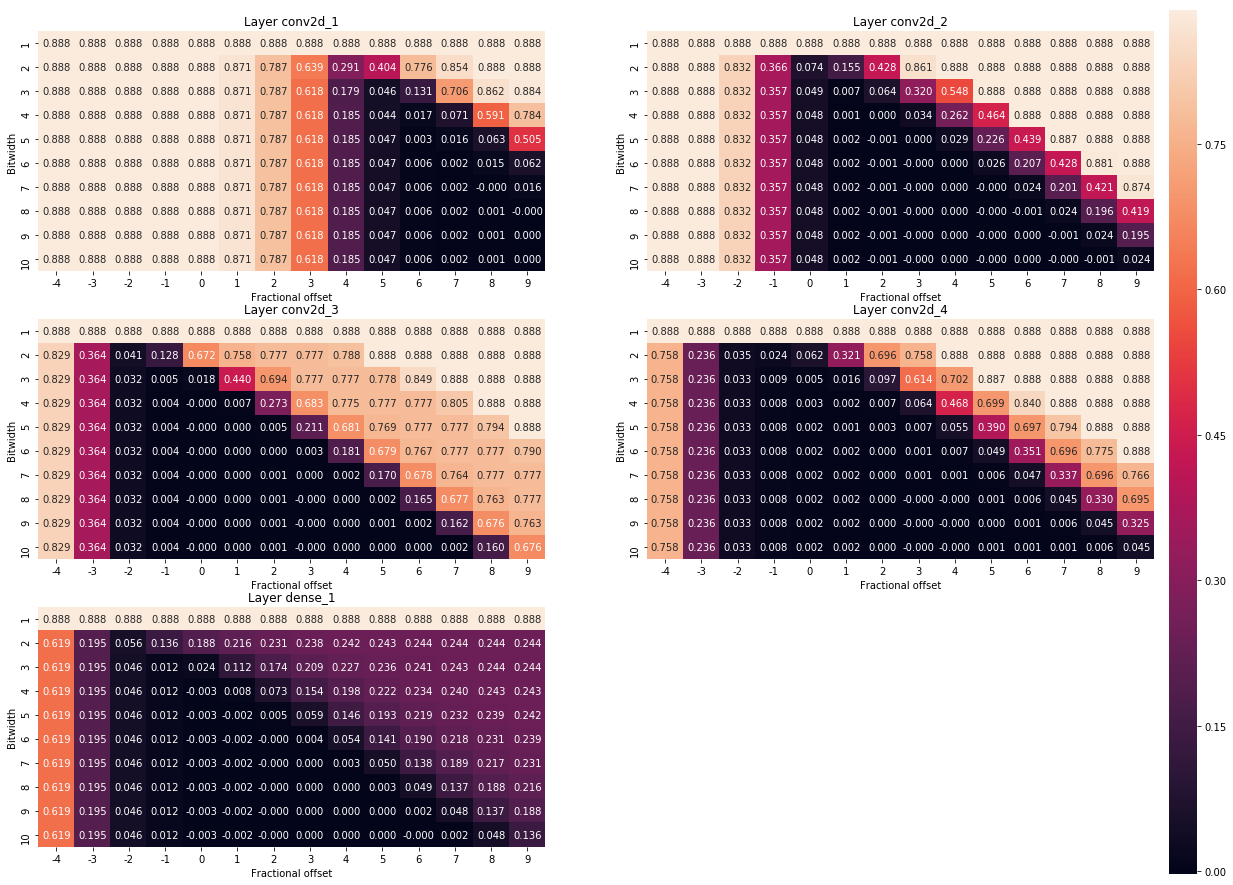

In [32]:
plot_results(scores_1, layer_names, 3, 2, (20, 15), 0.8, bw_range, f_range, vmax=vmax)

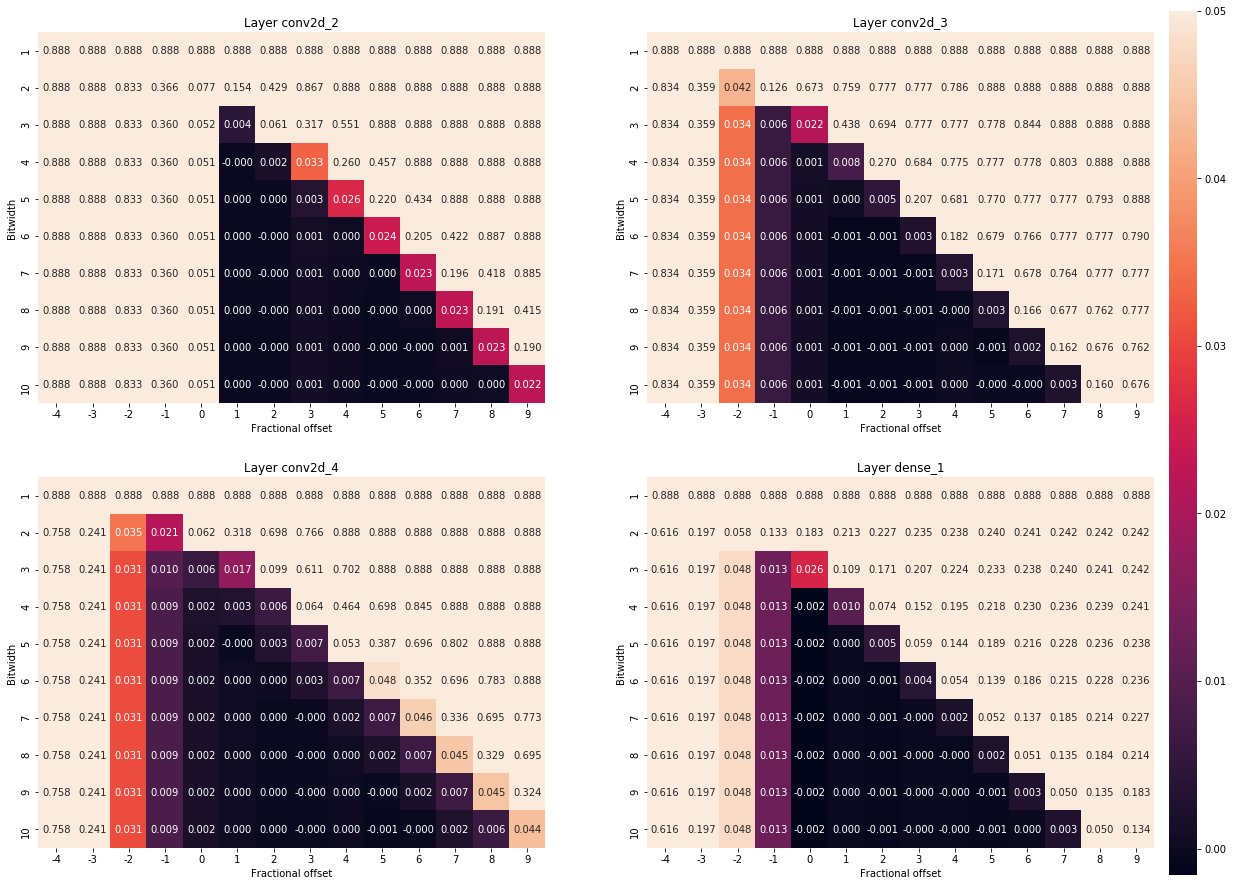

In [46]:
plot_results(scores_2_1, layer_names[1:], 2, 2, (20, 15), 0.8, bw_range, f_range, vmax=vmax)

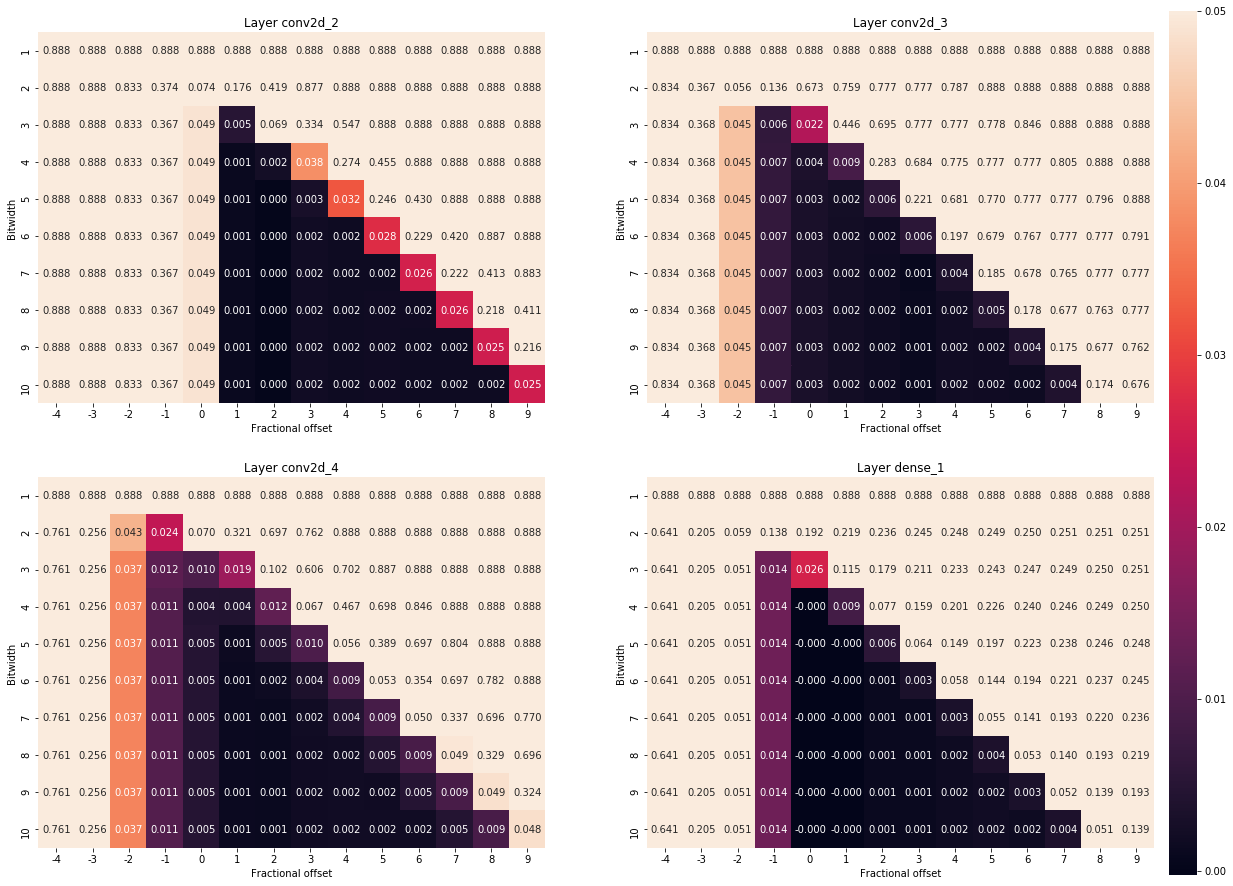

In [47]:
plot_results(scores_2_2, layer_names[1:], 2, 2, (20, 15), 0.8, bw_range, f_range, vmax=vmax)

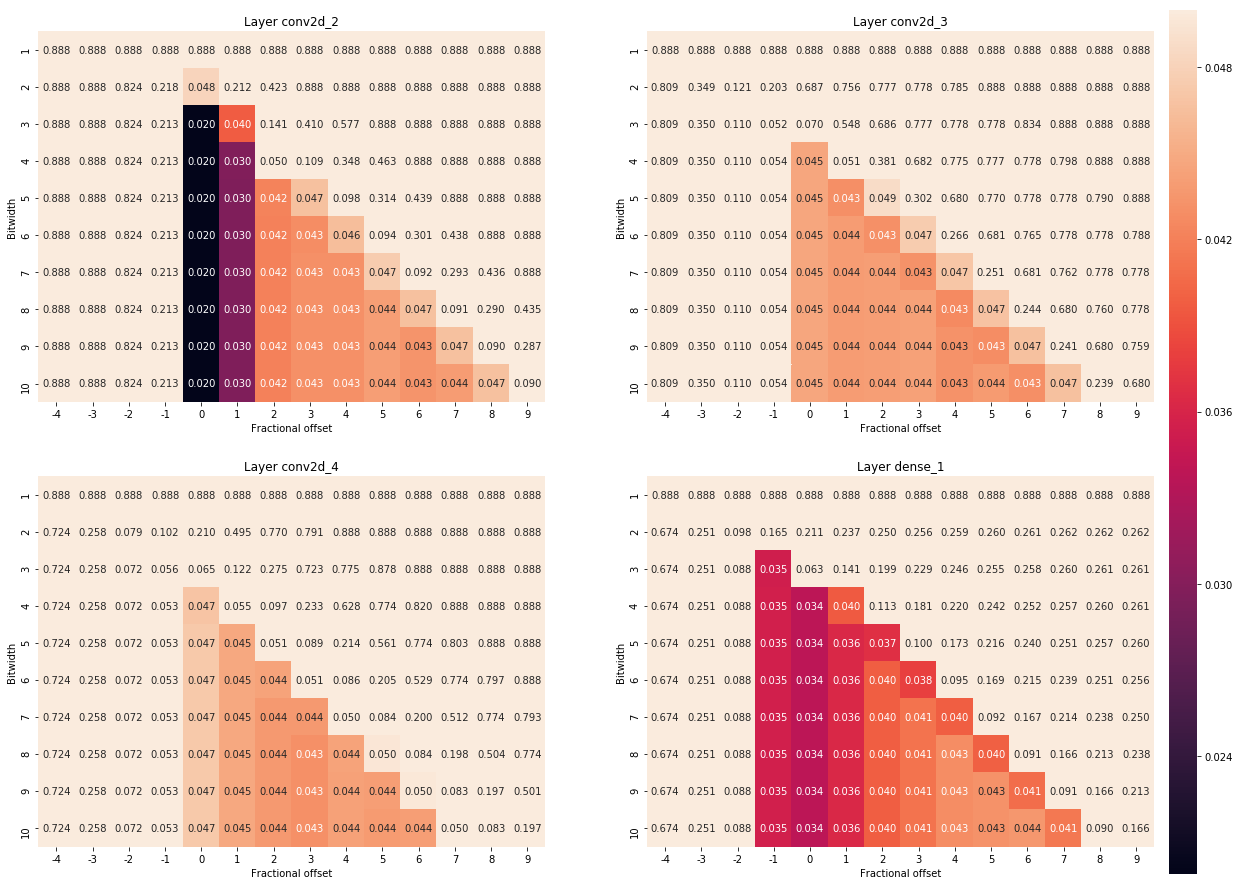

In [48]:
plot_results(scores_2_3, layer_names[1:], 2, 2, (20, 15), 0.8, bw_range, f_range, vmax=vmax)

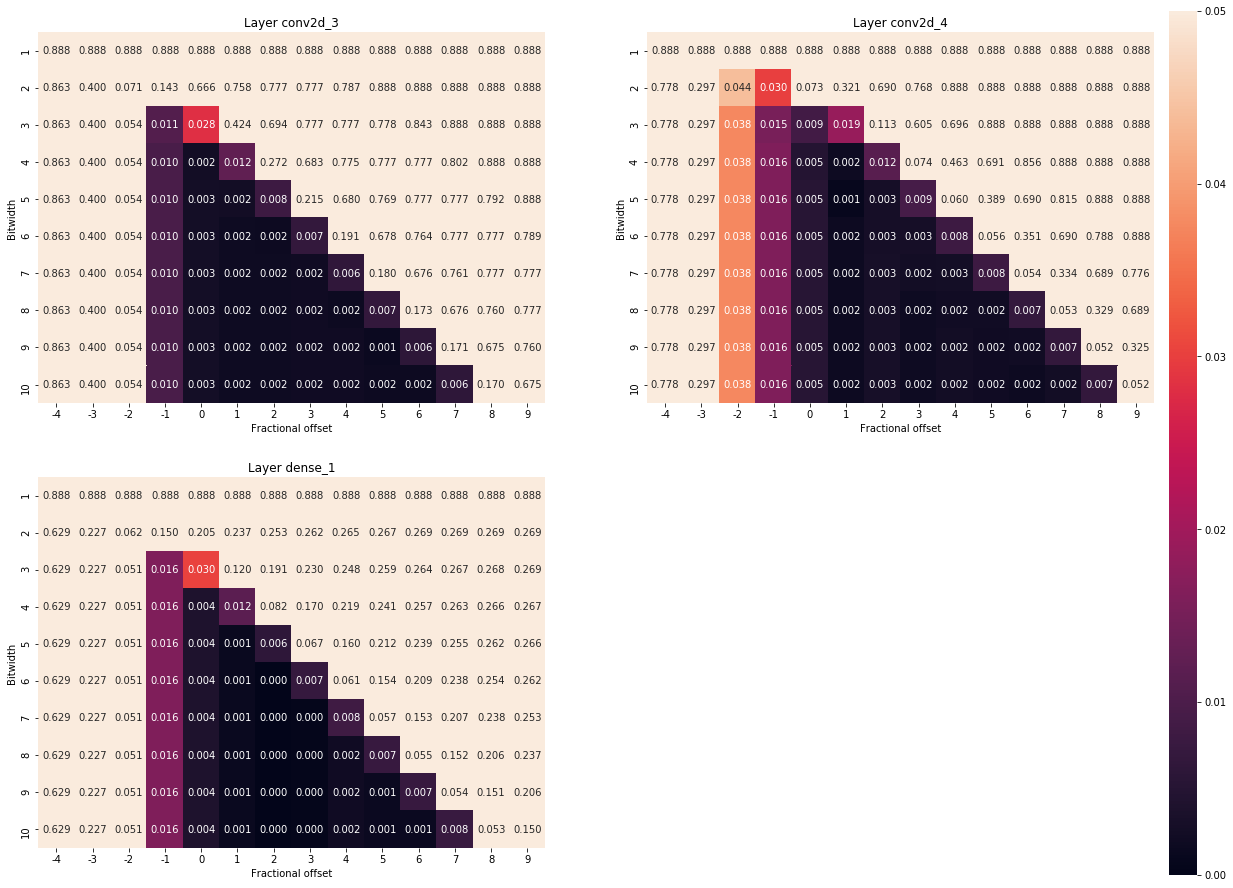

In [49]:
plot_results(scores_3, layer_names[2:], 2, 2, (20, 15), 0.8, bw_range, f_range, vmax=vmax)

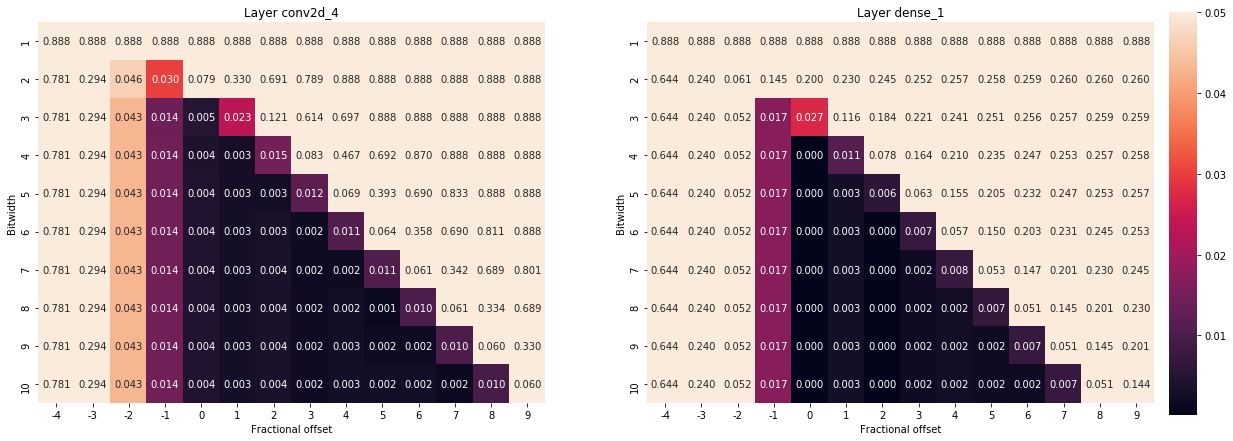

In [50]:
plot_results(scores_4, layer_names[3:], 1, 2, (20, 7), 0.8, bw_range, f_range, vmax=vmax)

C:\Users\320060820\Anaconda3\envs\tf_gpu\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  after removing the cwd from sys.path.


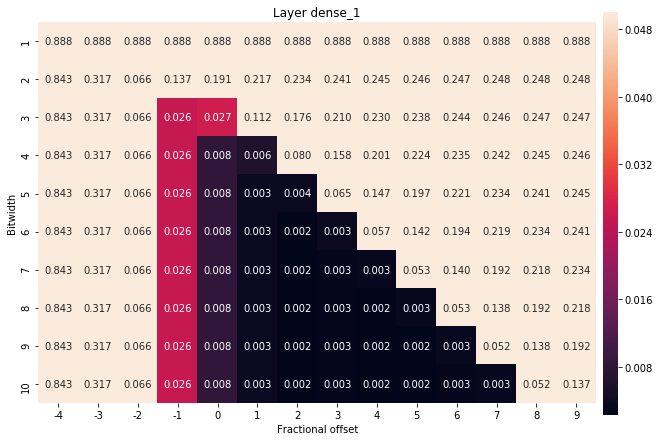

In [51]:
plot_results(scores_5, layer_names[4:], 1, 1, (10, 7), 0.8, bw_range, f_range, vmax=vmax)

##### Observations



#### Observing activations after quantization

In [11]:
keras_model = model_data.Model(name, test_data, model=keras_fashion.get_float_model())
print(f'Floating point model accuracy: {keras_model.evaluate_accuracy()[1]}')
act_maps_before_quant = keras_model.get_activation_maps(keras_model.x_test[0].reshape(1, 28, 28, 1), 'conv2d_2')

Floating point model accuracy: 0.895


In [12]:
parameters = {
    'conv2d_1': [7, 8],
    'conv2d_2': [4, 2],
    'conv2d_3': [4, 0],
    'conv2d_4': [4, 1],
    'dense_1': [5, 1]
}
keras_model = model_data.Model(name, test_data, model=keras_fashion.get_fxp_model(parameters))
print(f'Quantized fixed-point model accuracy: {keras_model.evaluate_accuracy()[1]}')
act_maps_after_quant = keras_model.get_activation_maps(keras_model.x_test[0].reshape(1, 28, 28, 1), 'lambda_2')

Quantized fixed-point model accuracy: 0.8919


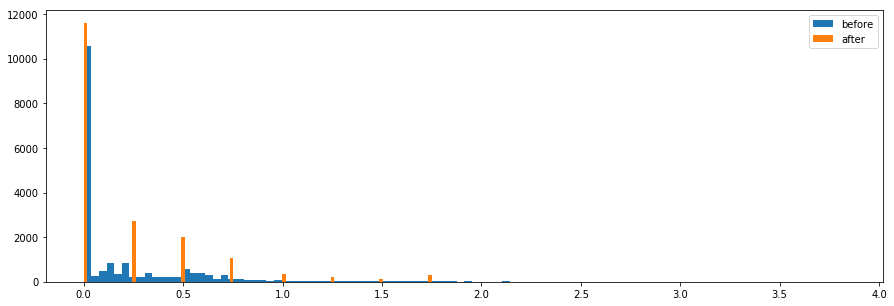

In [13]:
fig = plt.figure(figsize=(15, 5))
plt.hist(act_maps_before_quant.flat, bins=100, label='before');
plt.hist(act_maps_after_quant.flat, bins=100, label='after');
plt.legend()

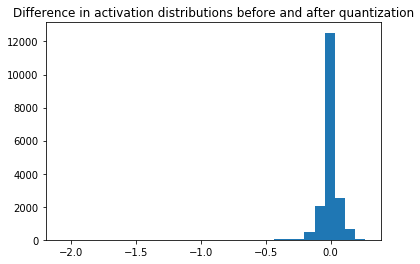

In [14]:
d = act_maps_after_quant - act_maps_before_quant
plt.hist(d.flat, bins=30);
plt.title('Difference in activation distributions before and after quantization');

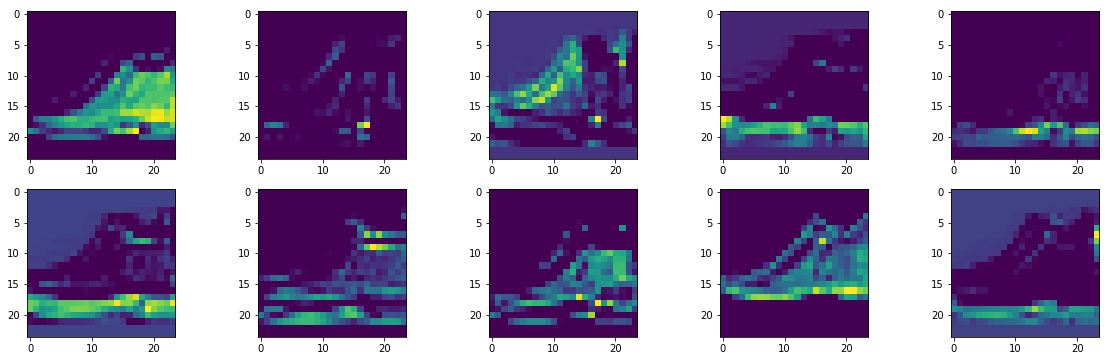

In [15]:
fig, axes = plt.subplots(2, 5, figsize=(20, 6))
ax = axes.flat
for i in range(10):
    ax[i].imshow(act_maps_before_quant[0, :, :, i])

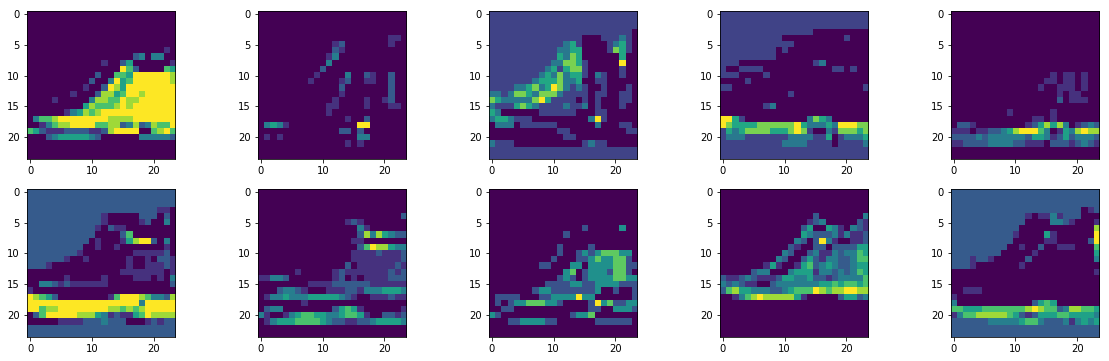

In [16]:
fig, axes = plt.subplots(2, 5, figsize=(20, 6))
ax = axes.flat
for i in range(10):
    ax[i].imshow(act_maps_after_quant[0, :, :, i])

### Reverse Quantization

In [17]:
parameters = {
    '1_1': {
        'dense_1': [5, 1]
    },
    '1_2': {
        'dense_1': [4, 0]
    },
    '2': {
        'conv2d_4': [4, 1],
        'dense_1': [5, 1]
    },
    '3': {
        'conv2d_3': [4, 0],
        'conv2d_4': [4, 1],
        'dense_1': [5, 1]
    },
    '4': {
        'conv2d_2': [4, 2],
        'conv2d_3': [4, 0],
        'conv2d_4': [4, 1],
        'dense_1': [5, 1]
    }
}

In [18]:
scores_r1_1 = brute_force_analysis(keras_fashion, name, test_data, layer_names[:-1], bw_range, f_range,
                                fix_quant=True, parameters=parameters['1_1'])
np.save(load_path + 'scores_r1_1', arr=scores_r1_1)

Layer conv2d_1 done.


Layer conv2d_2 done.


Layer conv2d_3 done.


Layer conv2d_4 done.


In [19]:
scores_r1_2 = brute_force_analysis(keras_fashion, name, test_data, layer_names[:-1], bw_range, f_range,
                                fix_quant=True, parameters=parameters['1_2'])
np.save(load_path + 'scores_r1_2', arr=scores_r1_2)

Layer conv2d_1 done.


Layer conv2d_2 done.


Layer conv2d_3 done.


Layer conv2d_4 done.


In [20]:
scores_r2 = brute_force_analysis(keras_fashion, name, test_data, layer_names[:-2], bw_range, f_range,
                                fix_quant=True, parameters=parameters['2'])
np.save(load_path + 'scores_r2', arr=scores_r2)

Layer conv2d_1 done.


Layer conv2d_2 done.


Layer conv2d_3 done.


In [21]:
scores_r3 = brute_force_analysis(keras_fashion, name, test_data, layer_names[:-3], bw_range, f_range,
                                fix_quant=True, parameters=parameters['3'])
np.save(load_path + 'scores_r3', arr=scores_r3)

Layer conv2d_1 done.


Layer conv2d_2 done.


In [22]:
scores_r4 = brute_force_analysis(keras_fashion, name, test_data, layer_names[:-4], bw_range, f_range,
                                fix_quant=True, parameters=parameters['4'])
np.save(load_path + 'scores_r4', arr=scores_r4)

Layer conv2d_1 done.


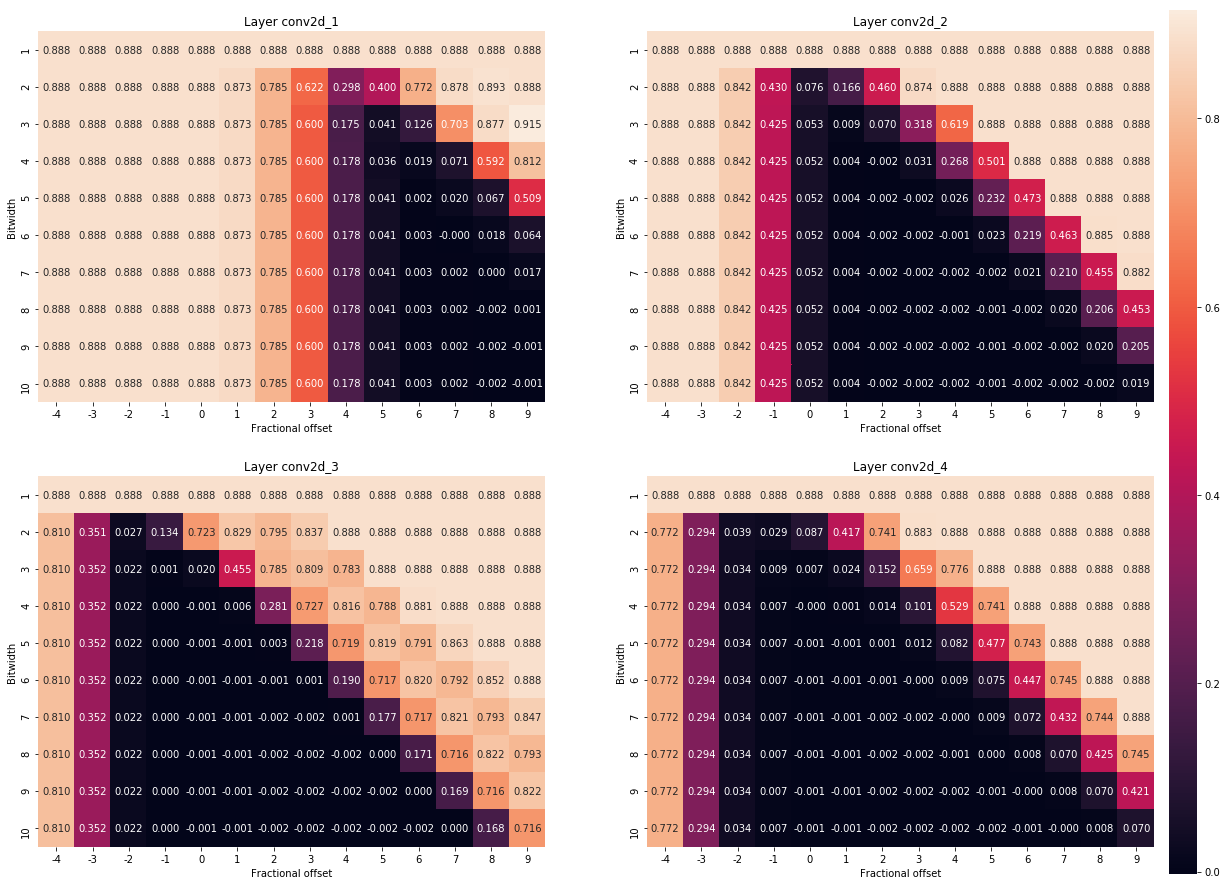

In [23]:
plot_results(scores_r1_1, layer_names[:-1], 2, 2, (20, 15), 0.8, bw_range, f_range)

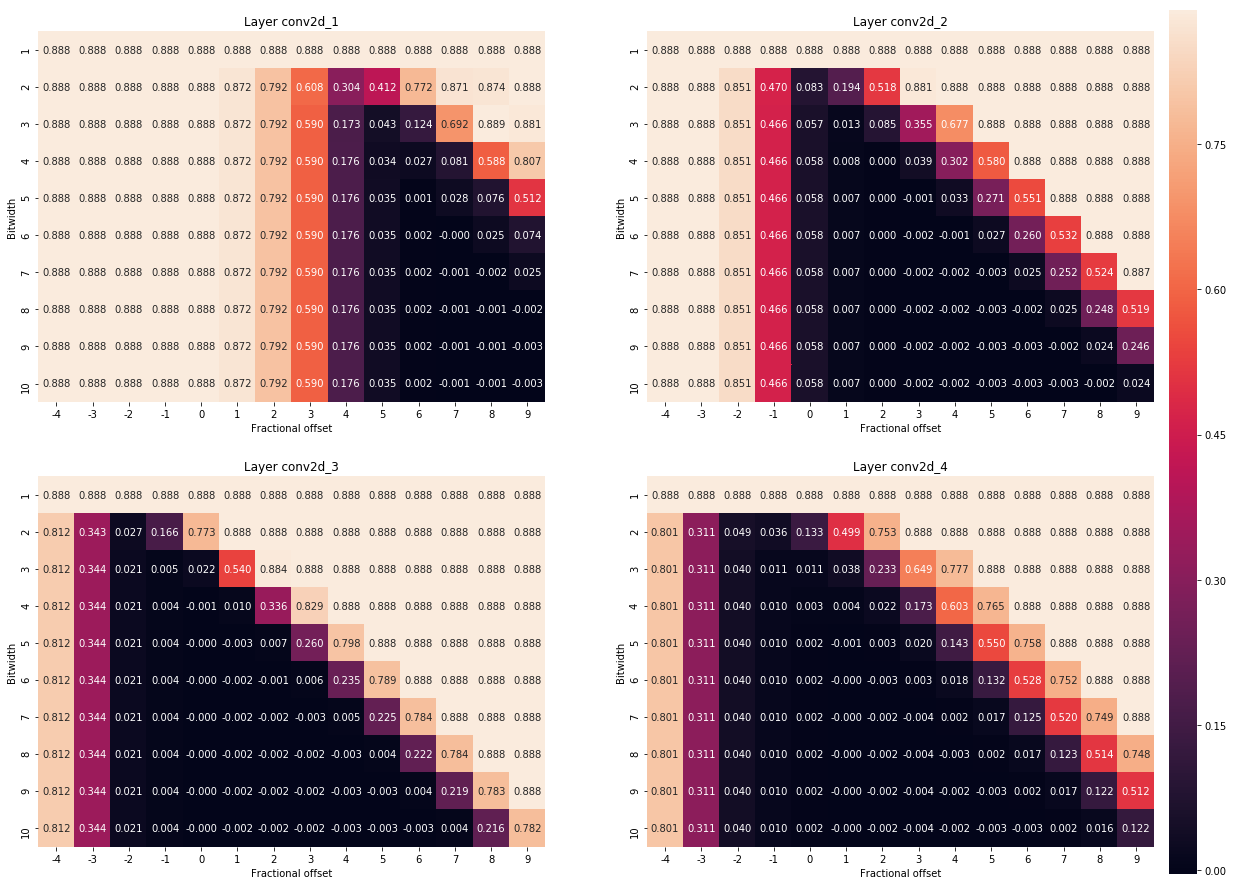

In [24]:
plot_results(scores_r1_2, layer_names[:-1], 2, 2, (20, 15), 0.8, bw_range, f_range)

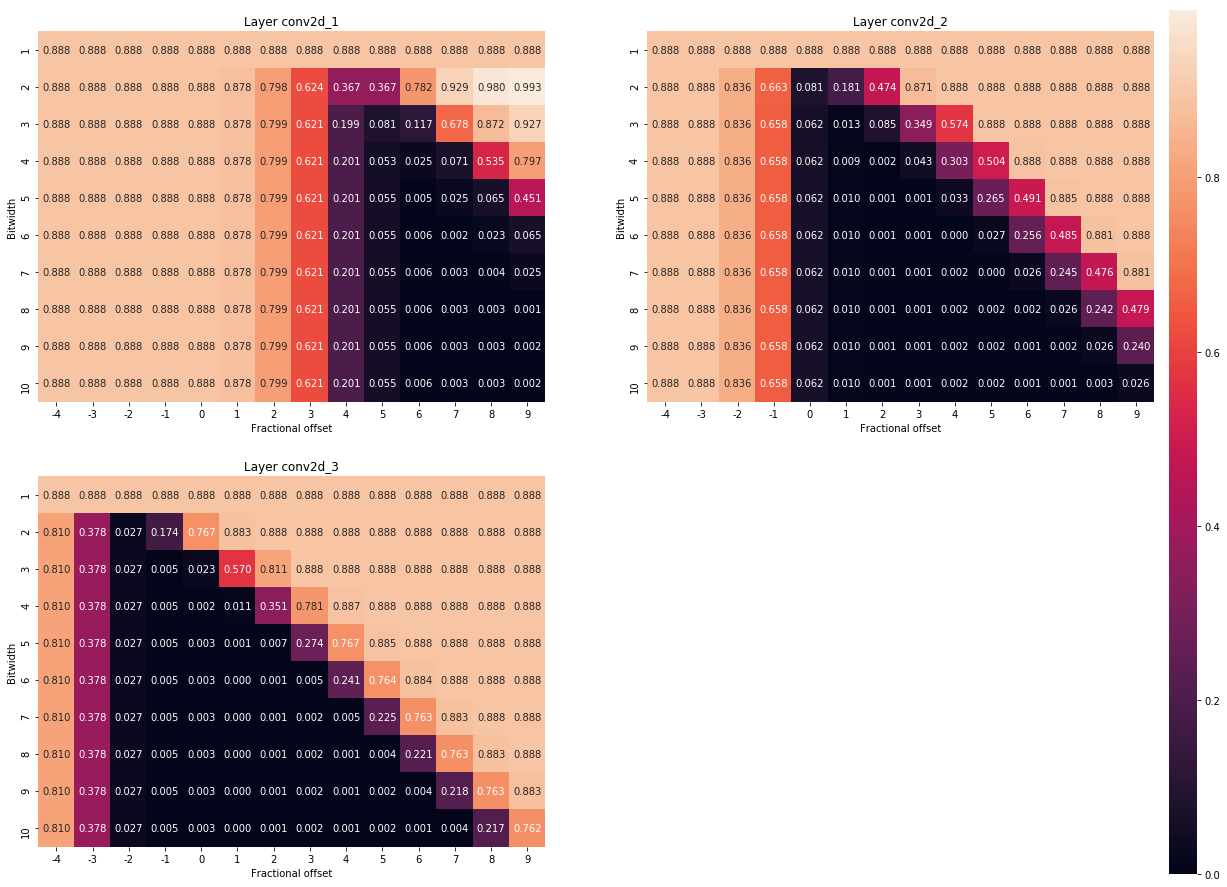

In [31]:
plot_results(scores_r2, layer_names[:-2], 2, 2, (20, 15), 0.8, bw_range, f_range)

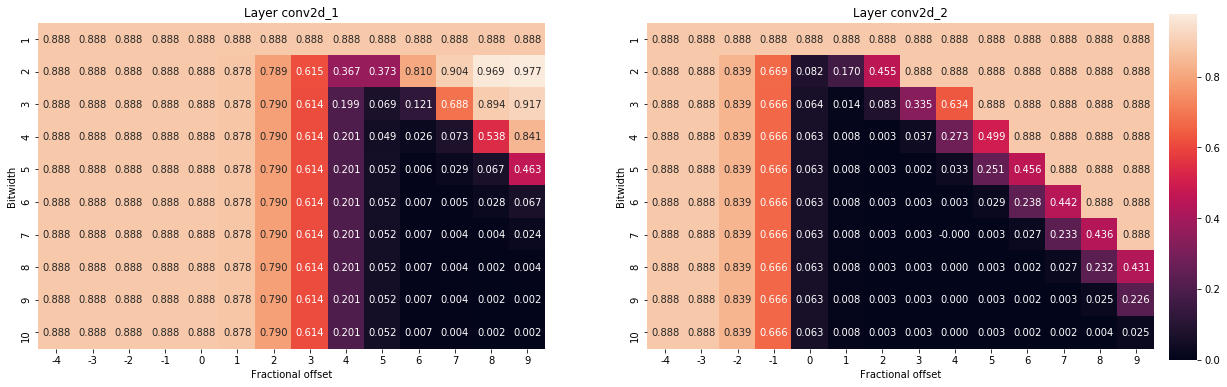

In [29]:
plot_results(scores_r3, layer_names[:-3], 1, 2, (20, 6), 0.8, bw_range, f_range)

C:\Users\320060820\Anaconda3\envs\tf_gpu\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  after removing the cwd from sys.path.


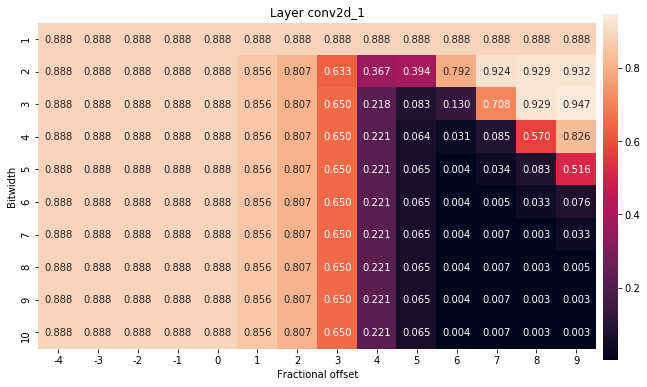

In [27]:
plot_results(scores_r4, layer_names[:-4], 1, 1, (10, 6), 0.8, bw_range, f_range)